In [1]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor

import tensorflow as tf
from tensorflow.keras.layers import (
    Dense, Input, LayerNormalization, MultiHeadAttention, Dropout, Flatten, Concatenate, Reshape, LSTM
)
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, Callback
from keras.layers import GRU, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, concatenate
from keras.regularizers import l2
import keras.backend as K


os.environ["CUDA_VISIBLE_DEVICES"] = "2" 

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7999)])
  except RuntimeError as e:
    print(e)
    
tf.random.set_seed(1234)


2025-02-11 14:25:45.548028: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-11 14:25:46.772963: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Feature Engineering

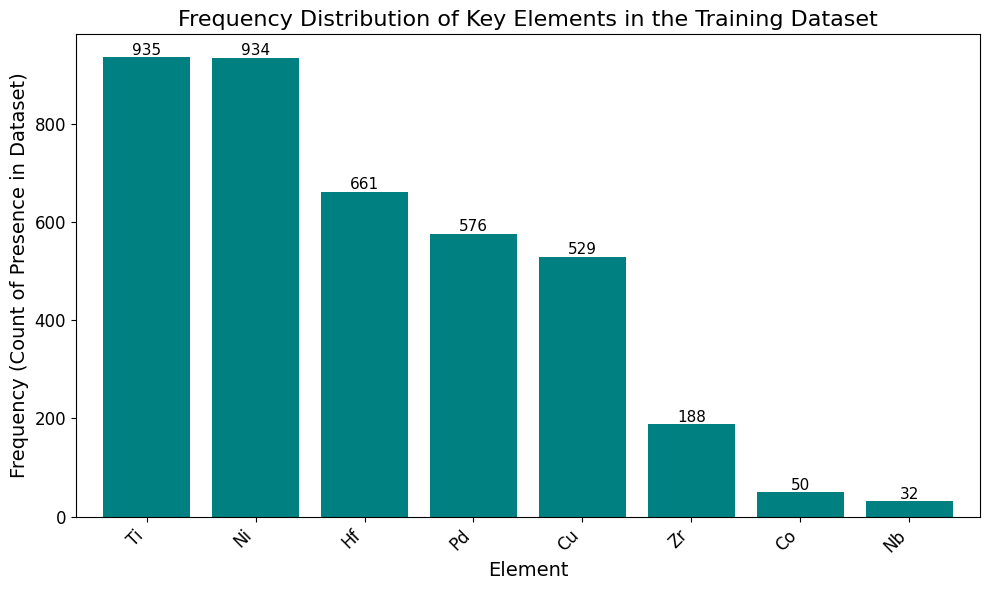

In [2]:
file_path = "/home1/nhuynh2023/Projects/Material_AF/DS_5_Ms_cleaned.csv"
data = pd.read_csv(file_path)

# Extracting key elements and processing conditions for the frequency distribution
elements = ["Ni", "Ti", "Hf", "Zr", "Cu", "Pd", "Co", "Nb"]
processing_conditions = ["Homogenization_temp", "Homogenization_time"]

# Summarizing the frequency of elements and processing conditions in the dataset
element_frequencies = data[elements].apply(lambda col: (col > 0).sum())
processing_frequencies = data[processing_conditions].apply(lambda col: (col > 0).sum())

# Combine the frequencies into a single DataFrame for plotting
frequencies = pd.concat([element_frequencies, processing_frequencies], axis=0)
frequencies.index.name = "Feature"
frequencies.name = "Frequency"

filtered_frequencies = element_frequencies.sort_values(ascending=False)

# Plotting the frequency distribution with gridlines removed
plt.figure(figsize=(10, 6))
filtered_frequencies.plot(kind="bar", color="teal", width=0.8)
plt.title("Frequency Distribution of Key Elements in the Training Dataset", fontsize=16)
plt.xlabel("Element", fontsize=14)
plt.ylabel("Frequency (Count of Presence in Dataset)", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
for index, value in enumerate(filtered_frequencies):
    plt.text(index, value + 5, str(value), ha='center', fontsize=11)  # Adding data labels

# Gridlines are fully removed
plt.gca().grid(False)
plt.tight_layout()
plt.show()




# Test with existing machine learning models

Training Random Forest...
Training Gradient Boosting...
Training Artificial Neural Network (ANN)...
Training XGBRegressor...
Training SVR...
Training Gaussian Process Regression (GPR)...
Training Extra Trees...
Training CatBoost...
+---+-----------------------------------+-----------+----------+-----------+
|   |               Model               | R² (Test) | MAE (°C) | RMSE (°C) |
+---+-----------------------------------+-----------+----------+-----------+
| 0 |        Random Forest (RF)         |   0.85    |   31.6   |   35.5    |
| 1 |  Gradient Boosting Machine (GBM)  |   0.88    |   26.9   |   29.1    |
| 2 |  Artificial Neural Network (ANN)  |   0.87    |   24.3   |   28.34   |
| 3 |           XGBRegressor            |    0.9    |   17.5   |   24.8    |
| 4 |  Support Vector Regression (SVR)  |   0.83    |   22.7   |   31.2    |
| 5 | Gaussian Process Regression (GPR) |   0.81    |   23.5   |   32.8    |
| 6 |         Extra Trees (ET)          |   0.86    |   20.4   |   29.7    

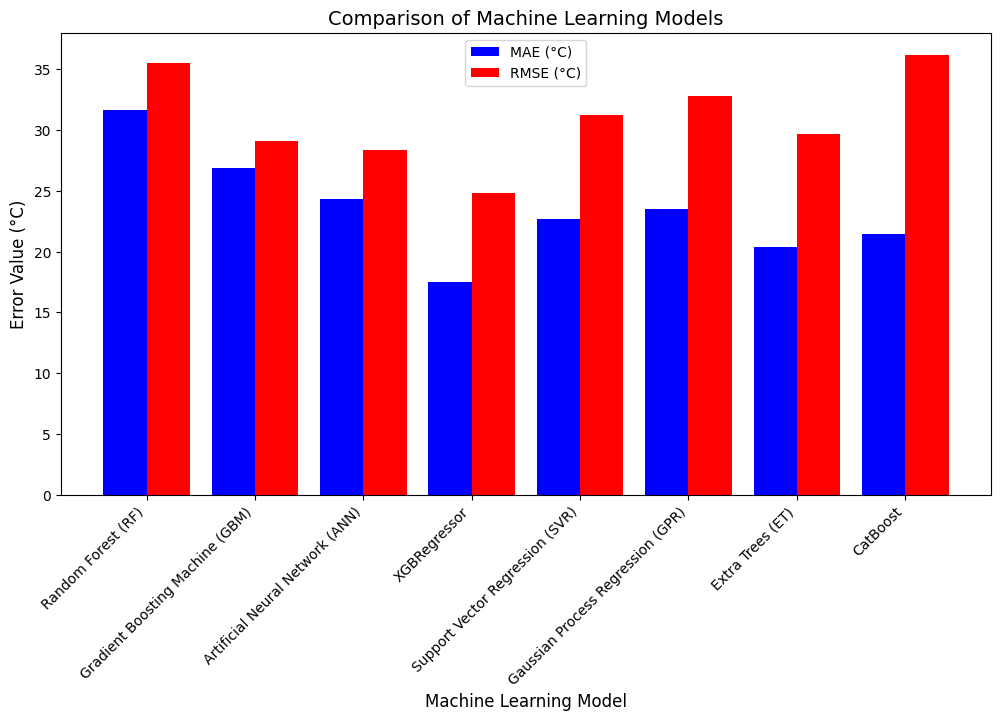

In [15]:
# Define features and target variable
X = data.drop(columns=["Ms"])  # Drop the target variable
y = data["Ms"]  # Define the target variable

# Split into train and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data (for models like SVR and GPR that are sensitive to feature scales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Artificial Neural Network (ANN)": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42),
    "XGBRegressor": XGBRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(kernel="rbf"),
    "Gaussian Process Regression (GPR)": GaussianProcessRegressor(),
    "Extra Trees": ExtraTreesRegressor(n_estimators=100, random_state=42),
    "CatBoost": CatBoostRegressor(n_estimators=100, verbose=0, random_state=42)
}

# Train and evaluate models
results = []
for name, model in models.items():
    print(f"Training {name}...")
    if name in ["SVR", "Gaussian Process Regression (GPR)"]:  # Use scaled data for SVR and GPR
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # Compute metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({"Model": name, "R²": r2, "MAE": mae, "RMSE": rmse })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results).sort_values(by="MAE")
results_df_sorted = results_df.sort_values(by="MAE")
results_df_sorted = results_df_sorted.round({"R²": 2, "MAE": 2, "RMSE": 2})

print(tabulate(results_df_sorted, headers='keys', tablefmt='pretty'))


# Plotting the performance of different models
plt.figure(figsize=(12, 6))
x_labels = results_df_sorted["Model"]
x = np.arange(len(x_labels))

plt.bar(x, results_df_sorted["MAE"], width=0.4, label="MAE", color="blue")
plt.bar(x + 0.4, results_df_sorted["RMSE"], width=0.4, label="RMSE", color="red")

plt.xticks(x + 0.2, x_labels, rotation=45, ha="right", fontsize=10)
plt.xlabel("Machine Learning Model", fontsize=12)
plt.ylabel("Error Value", fontsize=12)
plt.title("Comparison of Machine Learning Models", fontsize=14)
plt.legend()
plt.show()

# Prepare data for transformer

In [23]:
file_path = "/home1/nhuynh2023/Projects/Material_AF/DS_5_Ms_cleaned.csv"
data = pd.read_csv(file_path)

columns_to_drop = [12, -4, -5, -6, -7 ]
columns_to_drop = [col if col >= 0 else len(data.columns) + col for col in columns_to_drop]
columns_to_drop_names = data.columns[columns_to_drop]
# data = data.drop(columns=columns_to_drop_names)

# Print column names after dropping specified columns
print("Column names after dropping specified columns:")
print(data.columns)

# Convert specified columns to categorical
# categorical_columns = [' Aging_time', 'Aging_temp', 'Homogenization_time', 'Homogenization_temp']
categorical_columns = ['Homogenization_time', 'Homogenization_temp']
for col in categorical_columns:
    data[col] = data[col].astype('category')

# Apply one-hot encoding to the categorical columns
data_encoded = pd.get_dummies(data, columns=categorical_columns)

# Initialize the StandardScaler
scaler = StandardScaler()

# Selecting the independent variables (excluding 'Af')
X = data_encoded.drop('Ms', axis=1)

# Standardizing the independent variables
X_scaled = scaler.fit_transform(X)

# Creating a new DataFrame for the scaled independent variables
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Adding the original dependent variable 'Af' back to the DataFrame
scaled_data = X_scaled_df.copy()
scaled_data['Ms'] = data['Ms']

print(scaled_data.head())

# Extracting the target variable 'Af'
y = data['Ms']  # Use original target values

# Train-test split without scaling the target variable
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

# Print the first few rows of training features
print("\nTraining Features (X_train):")
print(pd.DataFrame(X_train, columns=X.columns).head())

# Print the first few rows of training target variable
print("\nTraining Target Variable (y_train):")
print(pd.DataFrame(y_train, columns=['Ms']).head())

nb_index = list(X.columns).index('Nb')
lstm_features_columns = X.columns[nb_index + 1:]  # All columns after 'Nb'

# Select these features for the LSTM branch
X_train_lstm = X_train[lstm_features_columns].values.reshape(X_train.shape[0], len(lstm_features_columns), 1)
X_test_lstm = X_test[lstm_features_columns].values.reshape(X_test.shape[0], len(lstm_features_columns), 1)

# Reshape data for the transformer model
X_train_transformer = X_train.iloc[:, 6:].values.reshape(X_train.shape[0], X_train.shape[1] - 6, 1)
X_test_transformer = X_test.iloc[:, 6:].values.reshape(X_test.shape[0], X_test.shape[1] - 6, 1)

# Standardize the target variable
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

# Create a timestamp for the folder name
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
data_dir = f'/home1/nhuynh2023/Projects/Material_AF/data/Ms/{timestamp}'
os.makedirs(data_dir, exist_ok=True)

# Save the training and testing datasets
train_set_path = os.path.join(data_dir, 'train_set.csv')
test_set_path = os.path.join(data_dir, 'test_set.csv')

train_set = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train, columns=['Ms'])], axis=1)
test_set = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test, columns=['Ms'])], axis=1)

train_set.to_csv(train_set_path, index=False)
test_set.to_csv(test_set_path, index=False)

print(f'Training set saved to: {train_set_path}')
print(f'Test set saved to: {test_set_path}')

# Print final column names after all preprocessing steps
print("Final column names after preprocessing:")
print(scaled_data.columns)

Column names after dropping specified columns:
Index(['Ni', 'Ti', 'Hf', 'Zr', 'Cu', 'Pd', 'Co', 'Nb', 'Homogenization_temp',
       'Homogenization_time', 'Aging_temp', ' Aging_time',
       'Applied Stress - (MPa) ', 'AM', 'BM', 'Tm', 'a', 'X', 'Smix', 'Hmix',
       'OMEGA', 'Delta', 'VEC', 'CV', 'Ionization energy',
       'Thermal conductivity', 'Electrical conductivity', 'Heat of fusion',
       'Heat of vaporization', 'Boiling point', 'Density', 'Vicker Hardness',
       'Ms'],
      dtype='object')
         Ni        Ti        Hf        Zr        Cu        Pd        Co   
0 -0.827703 -1.646238  0.411318  2.536564  3.219022 -0.788853 -0.194128  \
1 -0.827703 -1.646238  0.411318  2.536564  3.219022 -0.788853 -0.194128   
2  0.738835 -0.459378  0.771889 -0.424627 -0.015929 -0.788853 -0.194128   
3  0.793663 -0.726422  1.012270 -0.424627 -0.824666 -0.321485 -0.194128   
4  0.793663 -0.726422  1.012270 -0.424627 -0.824666 -0.321485 -0.194128   

         Nb  Aging_temp   Aging_time  

# Model architecture

In [24]:
# Define the transformer encoder
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

# Input for the first six features
input_dense = Input(shape=(6,))
x_dense = Dense(128, activation='relu')(input_dense)
x_dense = Dense(64, activation='relu')(x_dense)
x_dense = Dense(32, activation='relu')(x_dense)

# Input for the Transformer branch
input_transformer = Input(shape=(X_train_transformer.shape[1], 1))
x_transformer = transformer_encoder(input_transformer, head_size=256, num_heads=4, ff_dim=128, dropout=0.1)
x_transformer = transformer_encoder(x_transformer, head_size=256, num_heads=4, ff_dim=128, dropout=0.1)
x_transformer = transformer_encoder(x_transformer, head_size=256, num_heads=4, ff_dim=128, dropout=0.1)
x_transformer = Flatten()(x_transformer)

# Input for the LSTM branch
input_lstm = Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))
x_lstm = LSTM(128, return_sequences=True, dropout=0.1)(input_lstm)
x_lstm = LSTM(64, return_sequences=False, dropout=0.1)(x_lstm)

# Concatenate the outputs from Dense, Transformer, and LSTM branches
combined = Concatenate()([x_dense, x_transformer, x_lstm])
combined = Dense(128, activation='relu')(combined)
combined = Dense(64, activation='relu')(combined)
outputs = Dense(1)(combined)

model = Model(inputs=[input_dense, input_transformer, input_lstm], outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model_dir = f"/home1/nhuynh2023/Projects/Material_AF/models/Ms/{timestamp}"
os.makedirs(model_dir, exist_ok=True)
checkpoint_filepath = os.path.join(model_dir, 'model_best_val_loss.h5')

# Create the ModelCheckpoint callback
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1)

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch % 100 == 0 and epoch != 0:
        lr = lr * 0.9
    return lr

lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

# Train the model
history = model.fit(
    [X_train.iloc[:, :6], X_train_transformer, X_train_lstm],  # Provide all three inputs
    y_train,
    epochs=300,
    validation_data=([X_test.iloc[:, :6], X_test_transformer, X_test_lstm], y_test),  # Include the third input for validation
    verbose=1,
    callbacks=[model_checkpoint_callback, lr_scheduler, early_stopping]
)


loss, mae = model.evaluate([X_test.iloc[:, :6], X_test_transformer, X_test_lstm], y_test, verbose=0)
print(f'Test loss: {loss}')
print(f'Test MAE: {mae}')

model_save_path = os.path.join(model_dir, 'final_model.h5')
model.save(model_save_path)
print(f'Final model saved to: {model_save_path}')

2025-02-11 14:51:32.732059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-02-11 14:51:32.733214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-02-11 14:51:32.733983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/300


2025-02-11 14:51:33.264410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-02-11 14:51:33.265517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-02-11 14:51:33.266351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

22/24 [==========================>...] - ETA: 0s - loss: 1.0480 - mae: 0.7832

2025-02-11 14:51:44.728426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-02-11 14:51:44.729468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-02-11 14:51:44.730232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 0.73804, saving model to /home1/nhuynh2023/Projects/Material_AF/models/Ms/2025-02-11_14-51-28/model_best_val_loss.h5
24/24 [==============================] - 12s 59ms/step - loss: 1.0198 - mae: 0.7716 - val_loss: 0.7380 - val_mae: 0.6264 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/300
22/24 [==========================>...] - ETA: 0s - loss: 0.5937 - mae: 0.5730
Epoch 2: val_loss improved from 0.73804 to 0.54207, saving model to /home1/nhuynh2023/Projects/Material_AF/models/Ms/2025-02-11_14-51-28/model_best_val_loss.h5
24/24 [==============================] - 1s 26ms/step - loss: 0.5701 - mae: 0.5600 - val_loss: 0.5421 - val_mae: 0.5354 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/300
22/24 [==========================>...] - ETA: 0s - loss: 0.4266 - mae: 0.4782
Epoch 3: val_loss improved from 0.54207 to 0.47710, saving model to /home1/n

# Training progress

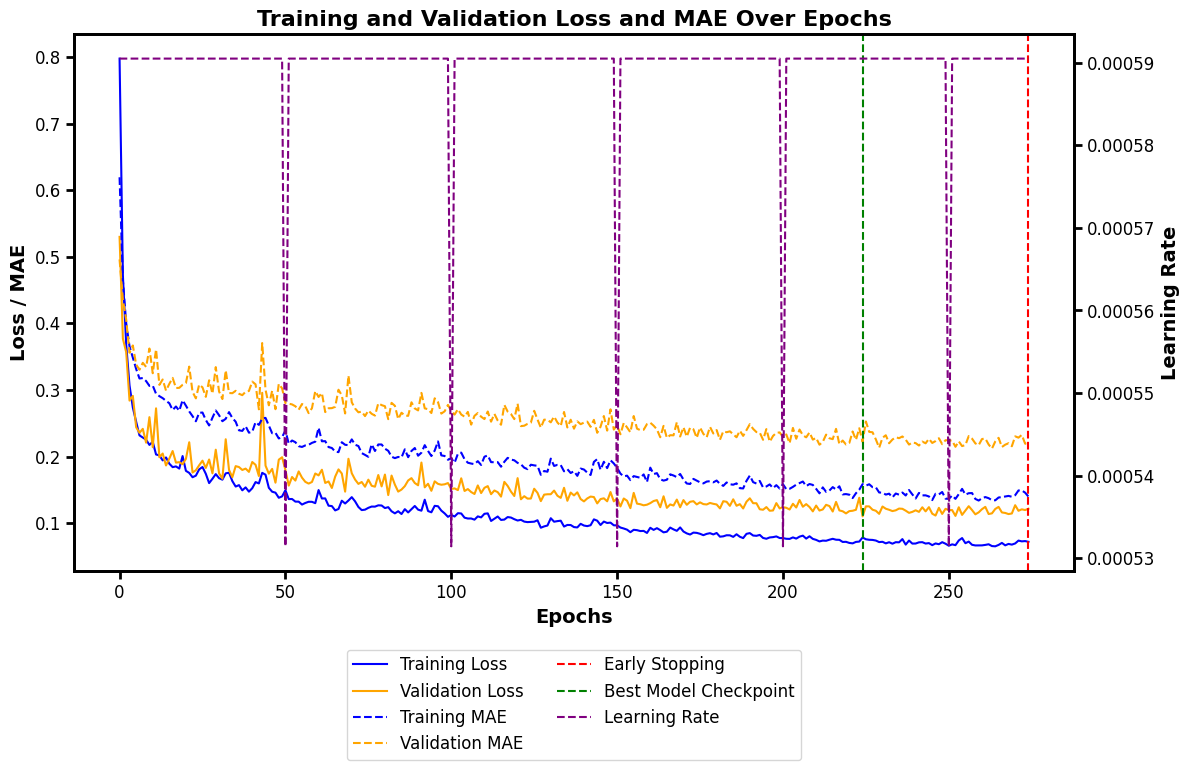

In [14]:

# Plot the training and validation loss with enhanced style
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot losses and MAE
ax1.plot(history.history['loss'], label='Training Loss', color='blue')
ax1.plot(history.history['val_loss'], label='Validation Loss', color='orange')
ax1.plot(history.history['mae'], label='Training MAE', color='blue', linestyle='--')
ax1.plot(history.history['val_mae'], label='Validation MAE', color='orange', linestyle='--')

# Annotate early stopping point if it occurred
if hasattr(early_stopping, 'stopped_epoch') and early_stopping.stopped_epoch > 0:
    ax1.axvline(early_stopping.stopped_epoch, color='r', linestyle='--', label='Early Stopping')

# Annotate best model checkpoint
best_epoch = np.argmin(history.history['val_loss'])
ax1.axvline(best_epoch, color='g', linestyle='--', label='Best Model Checkpoint')

# Customizing labels and title
ax1.set_xlabel('Epochs', fontweight='bold', fontsize=14)
ax1.set_ylabel('Loss / MAE', fontweight='bold', fontsize=14)
ax1.set_title('Training and Validation Loss and MAE Over Epochs', fontweight='bold', fontsize=16)

# Adjust tick parameters
ax1.tick_params(axis='both', which='major', labelsize=12, width=2, length=6)

# Learning rate scheduler plot
ax2 = ax1.twinx()
try:
    learning_rates = [scheduler(epoch, model.optimizer.lr.numpy()) for epoch in range(len(history.history['loss']))]
    ax2.plot(learning_rates, color='purple', linestyle='--', label='Learning Rate')
    ax2.set_ylabel('Learning Rate', fontweight='bold', fontsize=14)
    ax2.tick_params(axis='both', which='major', labelsize=12, width=2, length=6)
except Exception as e:
    print(f"Learning rate scheduler plot skipped due to error: {e}")

for spine in ax1.spines.values():
    spine.set_linewidth(2)
for spine in ax2.spines.values():
    spine.set_linewidth(2)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels() if ax2.get_legend_handles_labels() else ([], [])
ax2.legend(lines + lines2, labels + labels2, loc='center', bbox_to_anchor=(0.5, -0.25), ncol=2, fontsize=12)

plt.tight_layout()
plt.show()


# Validation

21/21 [==============================] - 0s 5ms/step


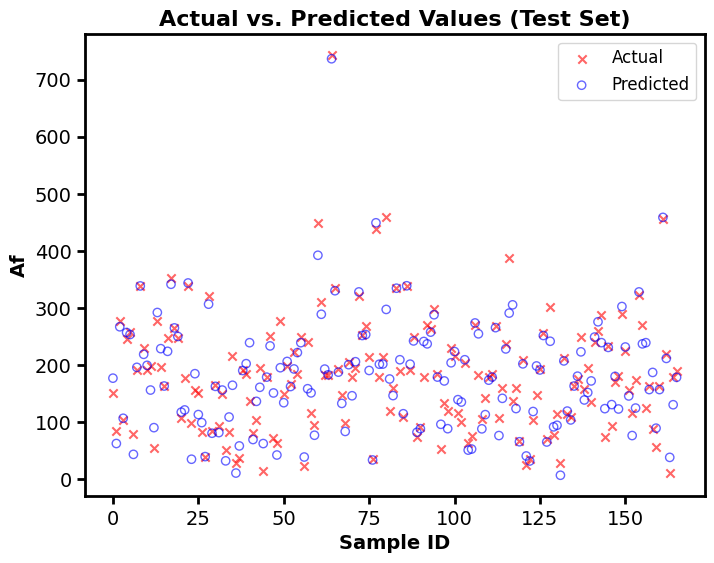

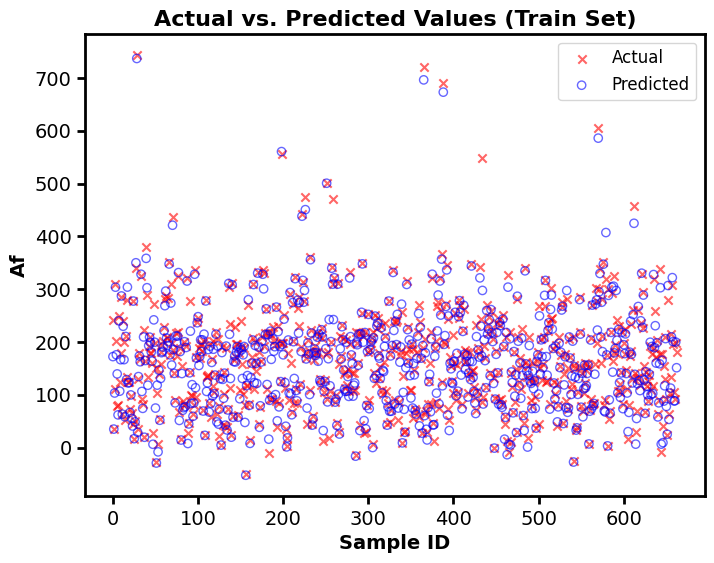

In [19]:
# model = load_model("/home1/nhuynh2023/Projects/Material_AF/models/Ms/2024-08-20_17-23-06/best_model.h5")

# ------------------ PREDICTIONS ------------------
y_pred_test = model.predict([X_test.iloc[:, :6], X_test_transformer, X_test_lstm])
y_pred_train = model.predict([X_train.iloc[:, :6], X_train_transformer, X_train_lstm])

# Inverse transform the predictions and original target values
y_pred_test_original = scaler_y.inverse_transform(y_pred_test)
y_test_original = scaler_y.inverse_transform(y_test)

y_pred_train_original = scaler_y.inverse_transform(y_pred_train)
y_train_original = scaler_y.inverse_transform(y_train)

# ------------------ PLOT FOR TEST SET ------------------
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test_original)), y_test_original, 
            label='Actual', color='red', alpha=0.6, marker='x')
plt.scatter(range(len(y_test_original)), y_pred_test_original, 
            label='Predicted', edgecolors='blue', facecolors='none', alpha=0.6, marker='o')

plt.xlabel('Sample ID', fontweight='bold', fontsize=14)
plt.ylabel('Ms', fontweight='bold', fontsize=14)  # Change to 'Af' if needed.
plt.title('Actual vs. Predicted Values (Test Set)', fontweight='bold', fontsize=16)
plt.legend(fontsize=12)


for spine in plt.gca().spines.values():
    spine.set_linewidth(2)
plt.gca().tick_params(axis='both', width=2, length=6, labelsize=14)
plt.grid(False)
plt.show()

# ------------------ PLOT FOR TRAIN SET ------------------
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_train_original)), y_train_original, 
            label='Actual', color='red', alpha=0.6, marker='x')
plt.scatter(range(len(y_train_original)), y_pred_train_original, 
            label='Predicted', edgecolors='blue', facecolors='none', alpha=0.6, marker='o')

plt.xlabel('Sample ID', fontweight='bold', fontsize=14)
plt.ylabel('Ms', fontweight='bold', fontsize=14)  # Change to 'Af' if needed.
plt.title('Actual vs. Predicted Values (Train Set)', fontweight='bold', fontsize=16)
plt.legend(fontsize=12)

for spine in plt.gca().spines.values():
    spine.set_linewidth(2)
plt.gca().tick_params(axis='both', width=2, length=6, labelsize=14)
plt.grid(False)
plt.show()

21/21 [==============================] - 0s 5ms/step
Test Mean Absolute Error (MAE): 20.251873618628224
Train Mean Absolute Error (MAE): 11.61331973097746


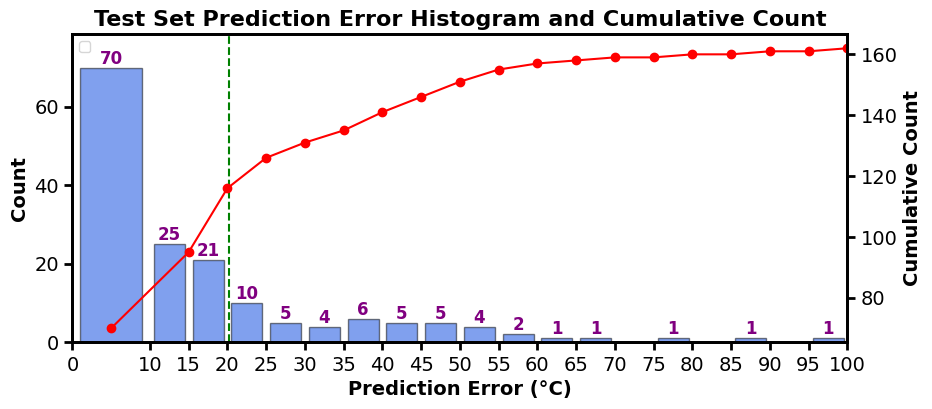

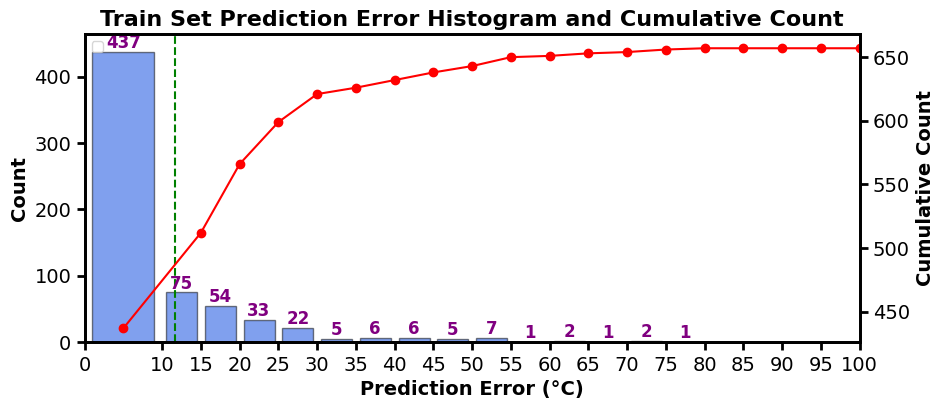

In [20]:
# ------------------ Calculate MAE and Errors ------------------

# Calculate mean absolute error (MAE) for test and train sets
mae_test = mean_absolute_error(y_test_original, y_pred_test_original)
mae_train = mean_absolute_error(y_train_original, y_pred_train_original)
print(f'Test Mean Absolute Error (MAE): {mae_test}')
print(f'Train Mean Absolute Error (MAE): {mae_train}')

# Calculate the absolute errors (you can also use signed errors if preferred)
errors_test = np.abs(y_pred_test_original - y_test_original).flatten()
errors_train = np.abs(y_pred_train_original - y_train_original).flatten()

# ------------------ Define Bin Edges and Ticks ------------------

# Define the custom bin edges for the histogram
bin_edges = np.concatenate(([0, 10], np.arange(15, 105, 5)))

# Set the x-axis ticks in the same way
x_ticks = np.concatenate(([0, 10], np.arange(15, 105, 5)))

# ------------------ Function to Plot Histogram and Cumulative Histogram ------------------

def plot_error_histogram(errors, mae, title):
    fig, ax1 = plt.subplots(figsize=(10, 4))
    
    # Plot the histogram with custom bin edges, colors, transparency, and bar width
    n, bins, patches = ax1.hist(errors, bins=bin_edges, color='#0343df', 
                                alpha=0.5, edgecolor='black', rwidth=0.8)
    
    # Annotate each bar with its count (if count > 0)
    for rect in patches:
        height = rect.get_height()
        if height > 0:
            ax1.text(rect.get_x() + rect.get_width() / 2.0, height, f'{int(height)}', 
                     ha='center', va='bottom', color='purple', fontweight='bold', fontsize=12)
    
    # Compute and plot the cumulative histogram on a secondary y-axis
    n_cumulative = np.cumsum(n)
    ax2 = ax1.twinx()
    # Compute the bin centers
    bin_centers = bins[:-1] + (bins[1] - bins[0]) / 2
    ax2.plot(bin_centers, n_cumulative, color='r', marker='o', linestyle='-')
    
    ax1.axvline(mae, color='green', linestyle='--')
    
    ax1.set_xlabel('Prediction Error (°C)', fontweight='bold', fontsize=14)
    ax1.set_ylabel('Count', fontweight='bold', fontsize=14)
    ax2.set_ylabel('Cumulative Count', fontweight='bold', fontsize=14)
    
    ax1.set_xticks(x_ticks)
    ax1.set_xlim(0, 100)
    ax1.set_ylim(0, ax1.get_ylim()[1] + 5)
    ax1.grid(False, axis='y')
    
    for spine in ax1.spines.values():
        spine.set_linewidth(2)
    for spine in ax2.spines.values():
        spine.set_linewidth(2)
    ax1.tick_params(axis='both', width=2, length=6, labelsize=14)
    ax2.tick_params(axis='both', width=2, length=6, labelsize=14)
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')
    
    plt.title(title, fontweight='bold', fontsize=16)
    plt.show()

# ------------------ Plot the Histograms ------------------

plot_error_histogram(errors_test, mae_test, 'Test Set Prediction Error Histogram and Cumulative Count')

plot_error_histogram(errors_train, mae_train, 'Train Set Prediction Error Histogram and Cumulative Count')